In [1]:
import netCDF4
import xarray as xr
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
os.chdir('/data/dhence/a/pborse2/inputdata/data.eol.ucar.edu/pub/download/extra/katz_data/stage4/daily_data')

In [2]:
fi = [f for f in glob.glob('*.nc')]

In [3]:
fi.sort()

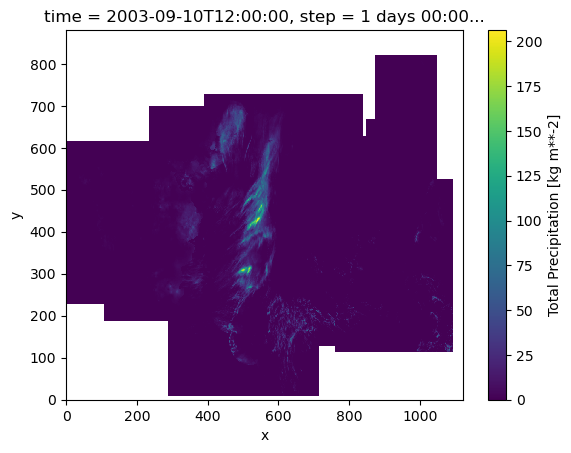

In [4]:
f = xr.open_dataset(fi[1])
f['tp'].sel(time="2003-9-10").plot()

In [40]:
f

<xarray.Dataset>
Dimensions:     (time: 364, x: 1121, y: 881)
Coordinates:
  * time        (time) datetime64[ns] 2019-01-01T12:00:00 ... 2019-12-31T12:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  (time) datetime64[ns] ...
Dimensions without coordinates: x, y
Data variables:
    tp          (time, y, x) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          4
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2022-07-28T19:08 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
import cartopy.crs as ccrs

In [5]:
def lat_lon_from_hrap(hrap_x, hrap_y):
    ####### Calculate the latitude and longitude for a HRAP grid.
    raddeg = 57.29577951
    earthrad = 6371.2
    stdlon = 105.
    mesh_len = 4.7625

    tlat = 60. / raddeg
    x = hrap_x - 401.
    y = hrap_y - 1601.
    rr = x * x + y * y
    gi = ((earthrad * (1 + np.sin(tlat))) / mesh_len)
    gi = gi * gi

    ll_y = np.arcsin((gi - rr) / (gi + rr)) * raddeg
    ang = np.arctan2(y, x) * raddeg
    if (ang < 0):
        ang = ang + 360.

    ll_x = 270 + stdlon - ang
    if (ll_x < 0):
        ll_x = ll_x + 360
    if (ll_x > 360):
        ll_x = ll_x - 360
    return ll_x, ll_y


lats = []
lons = []
lats1 = np.empty((881, 1121), dtype='float')
lons1= np.empty((881, 1121), dtype='float')
for i in range(881):
    hrap_x = 560
    hrap_y = i 
    lon, lat = lat_lon_from_hrap(hrap_x, hrap_y)
    lats.append(lat)
for j in range(1121):
    hrap_x = j
    hrap_y = 440
    lon, lat = lat_lon_from_hrap(hrap_x, hrap_y)
    lons.append(-lon)
for k in range(881):
    for l in range(1121):
        hrap_x = l
        hrap_y = k
        lon1, lat1 = lat_lon_from_hrap(hrap_x, hrap_y)
        lons1[i]=lon1
        lats1[i]=lat1

In [22]:
print(lat_lon_from_hrap(0,0),lat_lon_from_hrap(0,881),lat_lon_from_hrap(1121,0),lat_lon_from_hrap(1121,881))

(119.06150243769991, 23.05864284327942) (134.1153774364796, 53.459972551576165) (80.78564849685029, 19.76953897353037) (59.99999999757915, 45.61982902203868)


In [6]:
f['x'] = lons
f['y'] = lats

<AxesSubplot:title={'center':'time = 2003-09-10T12:00:00, step = 1 days 00:00...'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

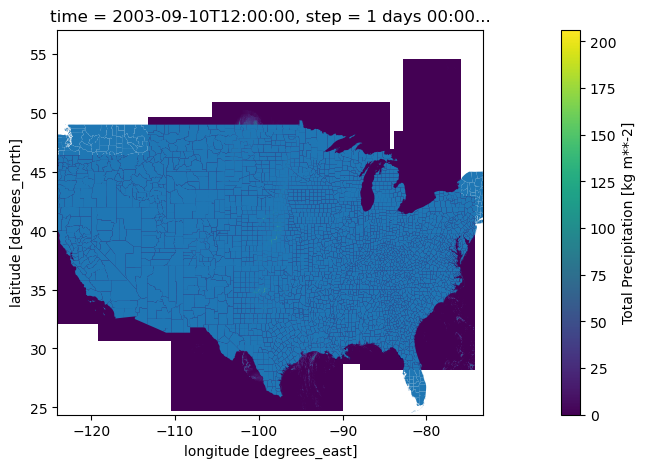

In [35]:
fig = plt.figure(figsize=[20,5])
ax = fig.add_subplot()

f['tp'].sel(time="2003-09-10").plot(ax=ax)
county.plot(ax=ax)

In [8]:
import rioxarray as rio
from pyproj import CRS
f = f.rio.write_crs("epsg:4326", inplace=True).rio.set_spatial_dims(x_dim="x",y_dim="y",inplace=True).rio.write_coordinate_system(inplace=True)
# f.to_netcdf('trial1.nc')

In [24]:
f = f.rio.write_crs("epsg:2163", inplace=True).rio.set_spatial_dims(x_dim="x",y_dim="y",inplace=True).rio.write_coordinate_system(inplace=True)

In [27]:
f

<xarray.Dataset>
Dimensions:      (time: 364, y: 881, x: 1121)
Coordinates:
  * time         (time) datetime64[ns] 2002-12-31T12:00:00 ... 2003-12-30T12:...
    step         timedelta64[ns] ...
    surface      float64 ...
    latitude     (y, x) float64 ...
    longitude    (y, x) float64 ...
    valid_time   (time) datetime64[ns] ...
  * x            (x) float64 -124.1 -124.0 -124.0 -123.9 ... -73.3 -73.27 -73.23
  * y            (y) float64 24.4 24.43 24.46 24.49 ... 56.92 56.97 57.01 57.05
    spatial_ref  int64 0
Data variables:
    tp           (time, y, x) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          4
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2022-07-28T18:23 GRIB to CDM+CF via cfgrib-0.9.1...

In [11]:
from osgeo import gdal
import cartopy.crs as ccrs
from pyproj import CRS
ds0 = gdal.Open('trial1.nc')
crs = CRS.from_string(ds0.GetProjection())

ModuleNotFoundError: No module named '_gdal'

In [23]:
ds = xr.open_dataset('trial1.nc')
ds = ds.rio.write_crs(crs.to_string(), inplace = True)

# Cartopy overlay trial

NameError: name 'ds' is not defined

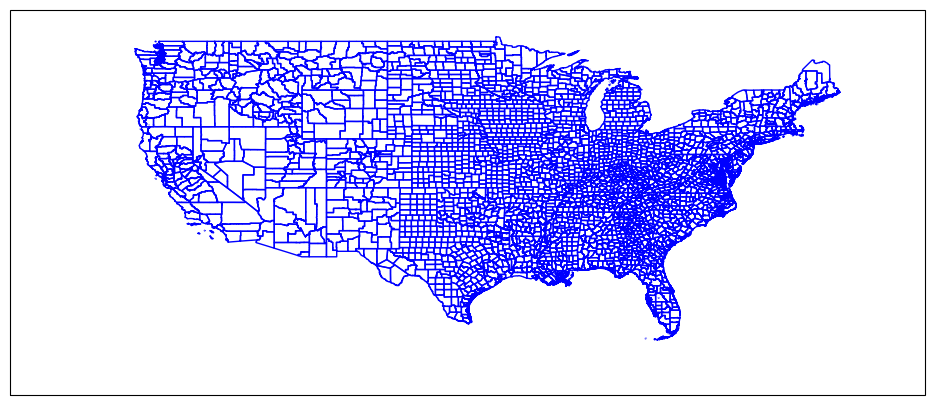

In [15]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt


reader = shpreader.Reader("USA_Counties-reprojected.shp")

counties = list(reader.geometries())

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(projection=ccrs.PlateCarree())

#ax.add_feature(cfeature.LAND.with_scale('50m'))

ax.add_feature(COUNTIES, facecolor='none', edgecolor='blue')


ax.set_extent([-135, -60, 20, 45])
#ax.set_extent([-3*10^7, 3*10^7, -3*10^6, 1*10^6])
#plt.pcolormesh(lons, lats, ds['tp'],zorder=2,transform=ccrs.PlateCarree())
ds['tp'].sel(time="2002-09-10").plot(ax=ax,transform=ccrs.PlateCarree())

plt.show()
#pcolormesh

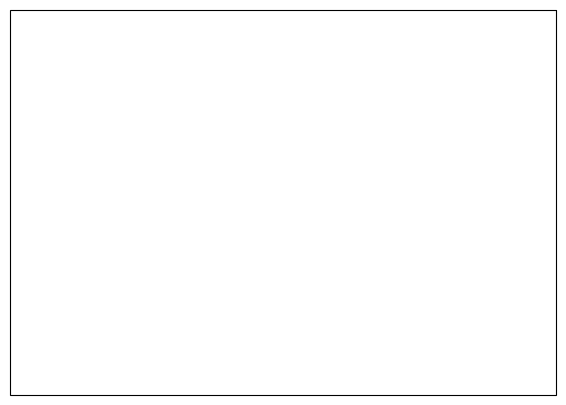

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt


reader = shpreader.Reader('/data/dhence/a/pborse2/inputdata/USA_Counties/USA_Counties.shp')

counties = list(reader.geometries())

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.NorthPolarStereo())

fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())

#ax.add_feature(cfeature.LAND.with_scale('50m'))

ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')



ax.set_extent([-3*10^7, 3*10^7, -3*10^6, 1*10^6])
#plt.pcolormesh(lons, lats, ds['tp'],zorder=2,transform=ccrs.PlateCarree())


plt.show()
#pcolormesh


In [13]:
counties

 ...]

# Clipping using geopandas

In [12]:
import geopandas as gpd
county = gpd.read_file("/data/dhence/a/pborse2/inputdata/USA_Counties/USA_Counties.shp")

In [13]:
county = county.to_crs(epsg=4326) #To convert to degrees
#county = county.to_crs(epsg=2163)
county.to_file('USA_Counties-reprojected.shp')

In [16]:
county1 = county.to_crs(epsg=2163)

<AxesSubplot:>

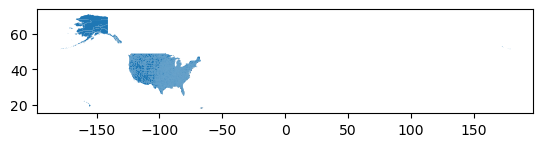

In [30]:
# county1['Geom'].plot()
county.plot()

In [27]:
county['lat'] = county.centroid.y
county['lon'] = county.centroid.x

/tmp/ipykernel_83819/1544167871.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  county['lat'] = county.centroid.y
/tmp/ipykernel_83819/1544167871.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  county['lon'] = county.centroid.x


In [13]:
####trying to convert shapefile to NorthPolarStereo()
import cartopy.crs as ccrs
crs = ccrs.NorthPolarStereo()
crs_proj4 = crs.proj4_init
# c = county.to_crs(crs_proj4)

In [84]:
c['angle'] = [90 for i in range(len(c))]

In [86]:
#c1=c.geometry.rotate(270)
from shapely.geometry import MultiPolygon
import shapely
c['rotated'] = c.apply(lambda row : shapely.affinity.rotate(row['geometry'], row['angle']), axis = 1)

/data/keeling/a/pborse2/miniconda3/envs/geo/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/data/keeling/a/pborse2/miniconda3/envs/geo/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/data/keeling/a/pborse2/miniconda3/envs/geo/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of p

<AxesSubplot:>

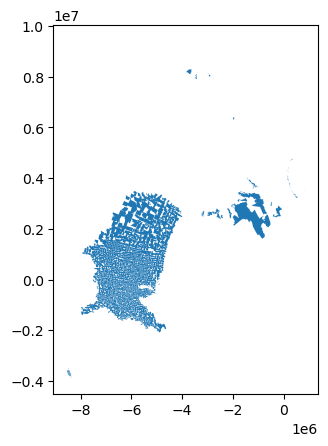

In [87]:
c['rotated'].plot()

<AxesSubplot:>

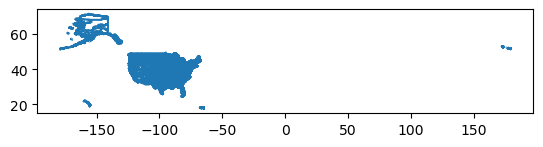

In [23]:
county.plot()  #[county['STATE_NAME']== 'Puerto Rico'].plot()

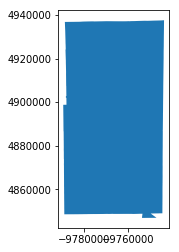

In [4]:
county[(county['NAME']=='Vermilion') & (county['STATE_NAME']== 'Illinois')].plot()

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os, glob
from scipy.stats import pearsonr
os.chdir("/data/dhence/a/pborse2/inputdata/data.eol.ucar.edu/pub/download/extra/katz_data/stage4/daily_data")

flist = [f for f in glob.glob('*.nc')] ## Yearly precipitation files
flist.sort()

In [3]:
def masked(ncfile): #Take the nc file as input
    # This csv file is used to select contiguous US
    state_df = pd.read_csv('/data/dhence/a/pborse2/inputdata/state_lookup.csv')
    state_df = state_df.loc[state_df['ContiguousUS'] == 1]
    # Shpfile for counties in US
    counties = gpd.read_file('/data/dhence/a/pborse2/inputdata/USA_Counties/USA_Counties.shp')
    counties = counties.loc[counties['STATE_NAME'].isin(state_df['Name'])]
    champ = gpd.read_file('/data/dhence/a/pborse2/inputdata/Champaign Zoning/Zoning.shp')
    
    # Reproject the counties gdf to polar stereographic projection
    # It is the most appropriate to match the netcdf's projection to display the contiguous US
#     import cartopy.crs as ccrs
    crs = ccrs.NorthPolarStereo()
    crs_proj4 = crs.proj4_init
    counties1 = counties.to_crs(crs_proj4)
    counties1 = counties1.rotate(105, origin=(0,0))
    counties['geometry'] = counties1
    
    ch1 = champ.to_crs(crs_proj4) ##Reprojecting shapefile for champaign city
    ch1 = ch1.rotate(105, origin=(0,0))
    champ['geometry']=ch1
    
    f = xr.open_dataarray(ncfile) ####INPUT ALERT####
    lonm = [((x-401)*4762.5)+170000 for x in f.x]
    latm = [((y-1601)*4762.5)-375237.5 for y in f.y] ##These formulae come from https://www.caee.utexas.edu/prof/maidment/gishyd97/library/nexrad/Sect3.pdf
    ###Value of latm is adjusted according to shapefile by subtracting 375237.5 in order to mask out correct region
#     lonm = [((x-401)*4762.5) for x in f.x]
#     latm = [((y-1601)*4762.5) for y in f.y]

    f['x']=lonm
    f['y']=latm
    
    #Assign a CRS to nc file as it's CRS is unknown in documentation but from website, it is polar stereographic 
    f = f.rio.write_crs(crs_proj4 , inplace=True)
    
    ## Mask out region of interest
    import salem
    f.attrs['pyproj_srs'] = crs_proj4
    ds = f.salem.roi(shape=counties[(counties['STATE_NAME']=='Illinois')&(counties['NAME']=='Champaign')])
    return ds,champ, counties, f

In [4]:
state_df = pd.read_csv('/data/dhence/a/pborse2/inputdata/state_lookup.csv')
state_df = state_df.loc[state_df['ContiguousUS'] == 1]
# Shpfile for counties in US
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

counties = gpd.read_file('/data/dhence/a/pborse2/inputdata/USA_Counties/USA_Counties.shp')
counties = counties.loc[counties['STATE_NAME'].isin(state_df['Name'])]

AttributeError: partially initialized module 'fiona' has no attribute '_loading' (most likely due to a circular import)

Text(0.5, 1.0, '')

/data/keeling/a/pborse2/miniconda39/envs/geonew/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:150: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


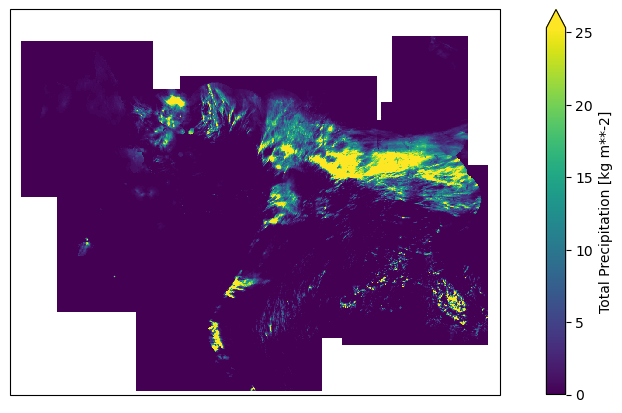

In [27]:

# f=masked(flist[2])
fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(projection=crs)
xr.open_dataarray(flist[2]).sel(time="2004-6-11").plot(ax=ax,robust=True)
# counties = f[2]

# counties.boundary.plot(ax=ax, lw=0.5, color='orange')
# counties[counties['STATE_NAME']=='Illinois'].boundary.plot(ax=ax, lw=0.5, color='white')
ax.add_feature(COUNTIES, facecolor='none', edgecolor='orange')
# You can use this to hide the numbers on both axis
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('')